In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.9680 | val loss 0.7716 | acc 0.2126 | f1 0.3506 | prec 0.2126 | recall 1.0000 | roc auc 0.5113 | pr auc 0.2443 | elapsed 26.82s
train epoch 01/10 | batch 1704/1703 | loss 0.7660 | val loss 0.5140 | acc 0.8135 | f1 0.3203 | prec 0.7113 | recall 0.2067 | roc auc 0.6429 | pr auc 0.4536 | elapsed 50.57s
train epoch 02/10 | batch 1704/1703 | loss 0.5179 | val loss 0.4451 | acc 0.8187 | f1 0.5242 | prec 0.5928 | recall 0.4699 | roc auc 0.7694 | pr auc 0.5974 | elapsed 48.88s
train epoch 03/10 | batch 1704/1703 | loss 0.3830 | val loss 0.4444 | acc 0.8260 | f1 0.5905 | prec 0.5908 | recall 0.5901 | roc auc 0.7994 | pr auc 0.6581 | elapsed 53.82s
train epoch 04/10 | batch 1704/1703 | loss 0.3004 | val loss 0.4623 | acc 0.8249 | f1 0.6088 | prec 0.5797 | recall 0.6410 | roc auc 0.8152 | pr auc 0.6953 | elapsed 53.73s
train epoch 05/10 | batch 1704/1703 | loss 0.2482 |

In [37]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, identities_weight=0.4, identitity_weight_decay=0.7, lr_encoder=0.001)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 1.9702 | val loss 1.2367 | acc 0.6422 | f1 0.4199 | prec 0.3166 | recall 0.6232 | roc auc 0.6868 | pr auc 0.4721 | elapsed 11.48s
train epoch 01/10 | batch 849/848 | loss 1.3183 | val loss 0.8422 | acc 0.7112 | f1 0.5053 | prec 0.3922 | recall 0.7101 | roc auc 0.7871 | pr auc 0.6023 | elapsed 21.14s
train epoch 02/10 | batch 849/848 | loss 0.7429 | val loss 0.7570 | acc 0.7347 | f1 0.5418 | prec 0.4225 | recall 0.7551 | roc auc 0.8194 | pr auc 0.6688 | elapsed 22.33s
train epoch 03/10 | batch 849/848 | loss 0.5300 | val loss 0.7147 | acc 0.7488 | f1 0.5583 | prec 0.4398 | recall 0.7640 | roc auc 0.8316 | pr auc 0.7011 | elapsed 19.75s
train epoch 04/10 | batch 849/848 | loss 0.4002 | val loss 0.6869 | acc 0.7597 | f1 0.5680 | prec 0.4533 | recall 0.7603 | roc auc 0.8379 | pr auc 0.7205 | elapsed 22.93s
train epoch 05/10 | batch 849/848 | loss 0.3115 | val loss 0.6633 | acc 0.7730 | f1 0.5823 | prec 0.4713 | recall 0.7618 | roc a

In [38]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240713T172501


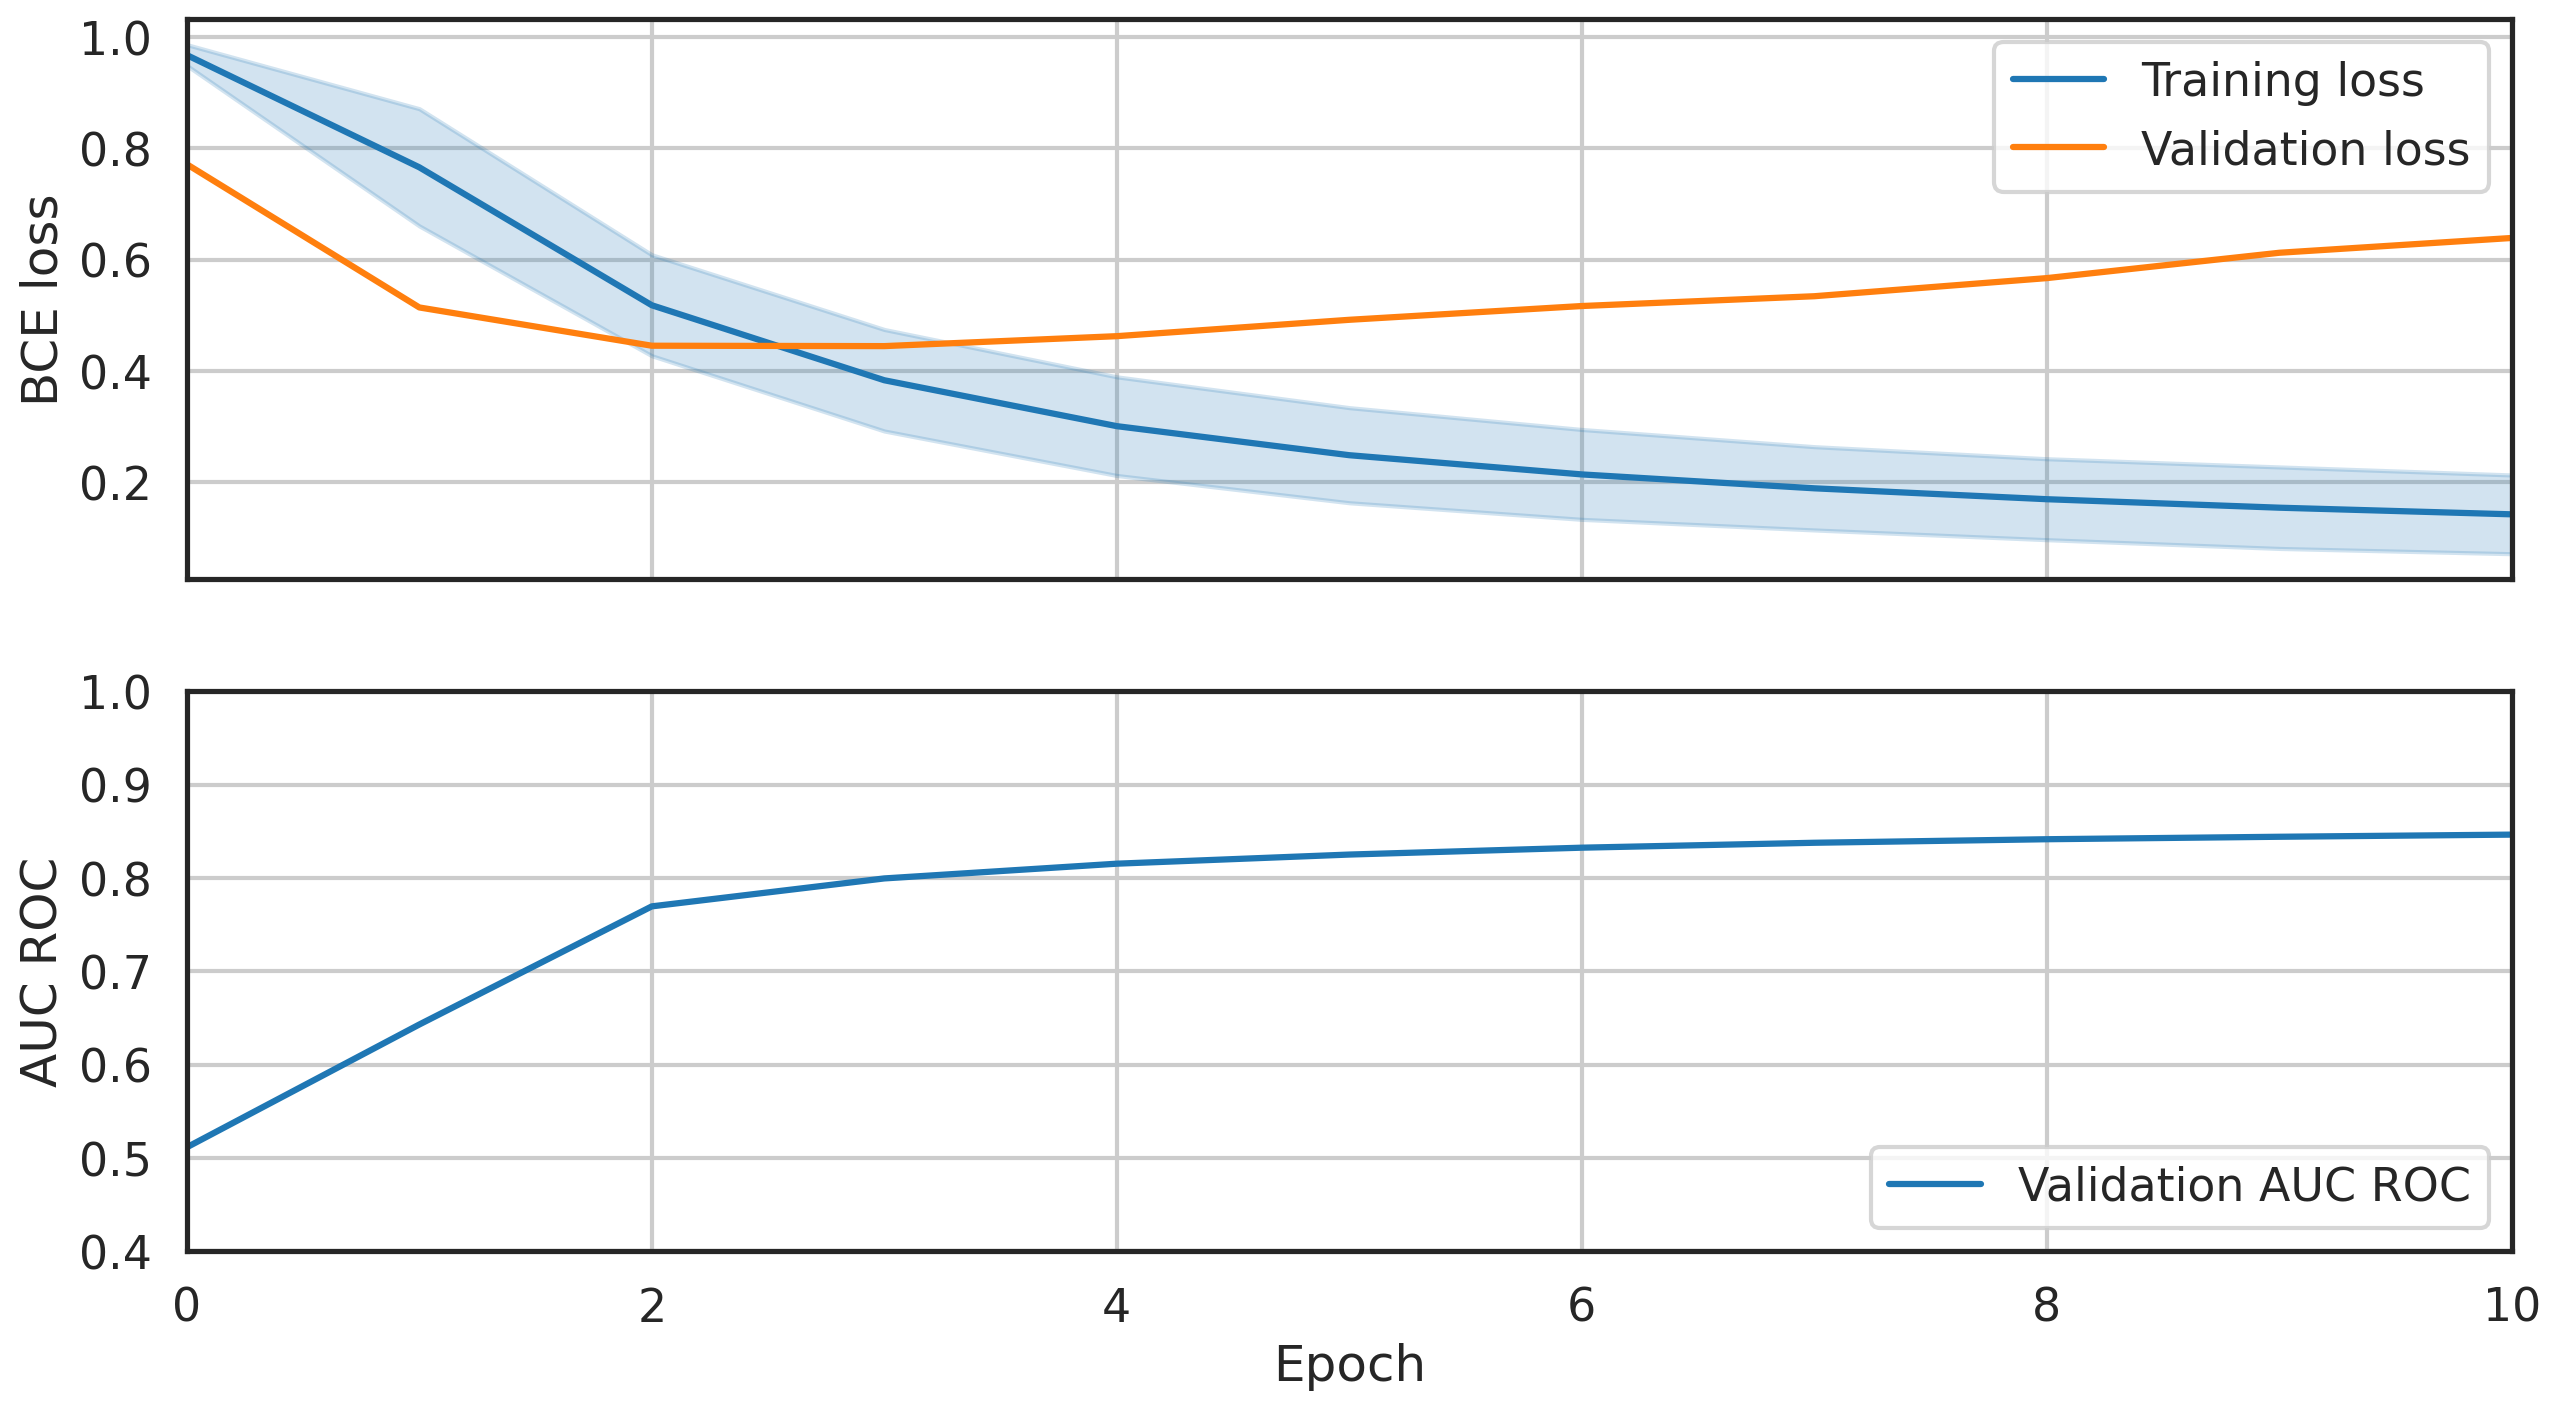

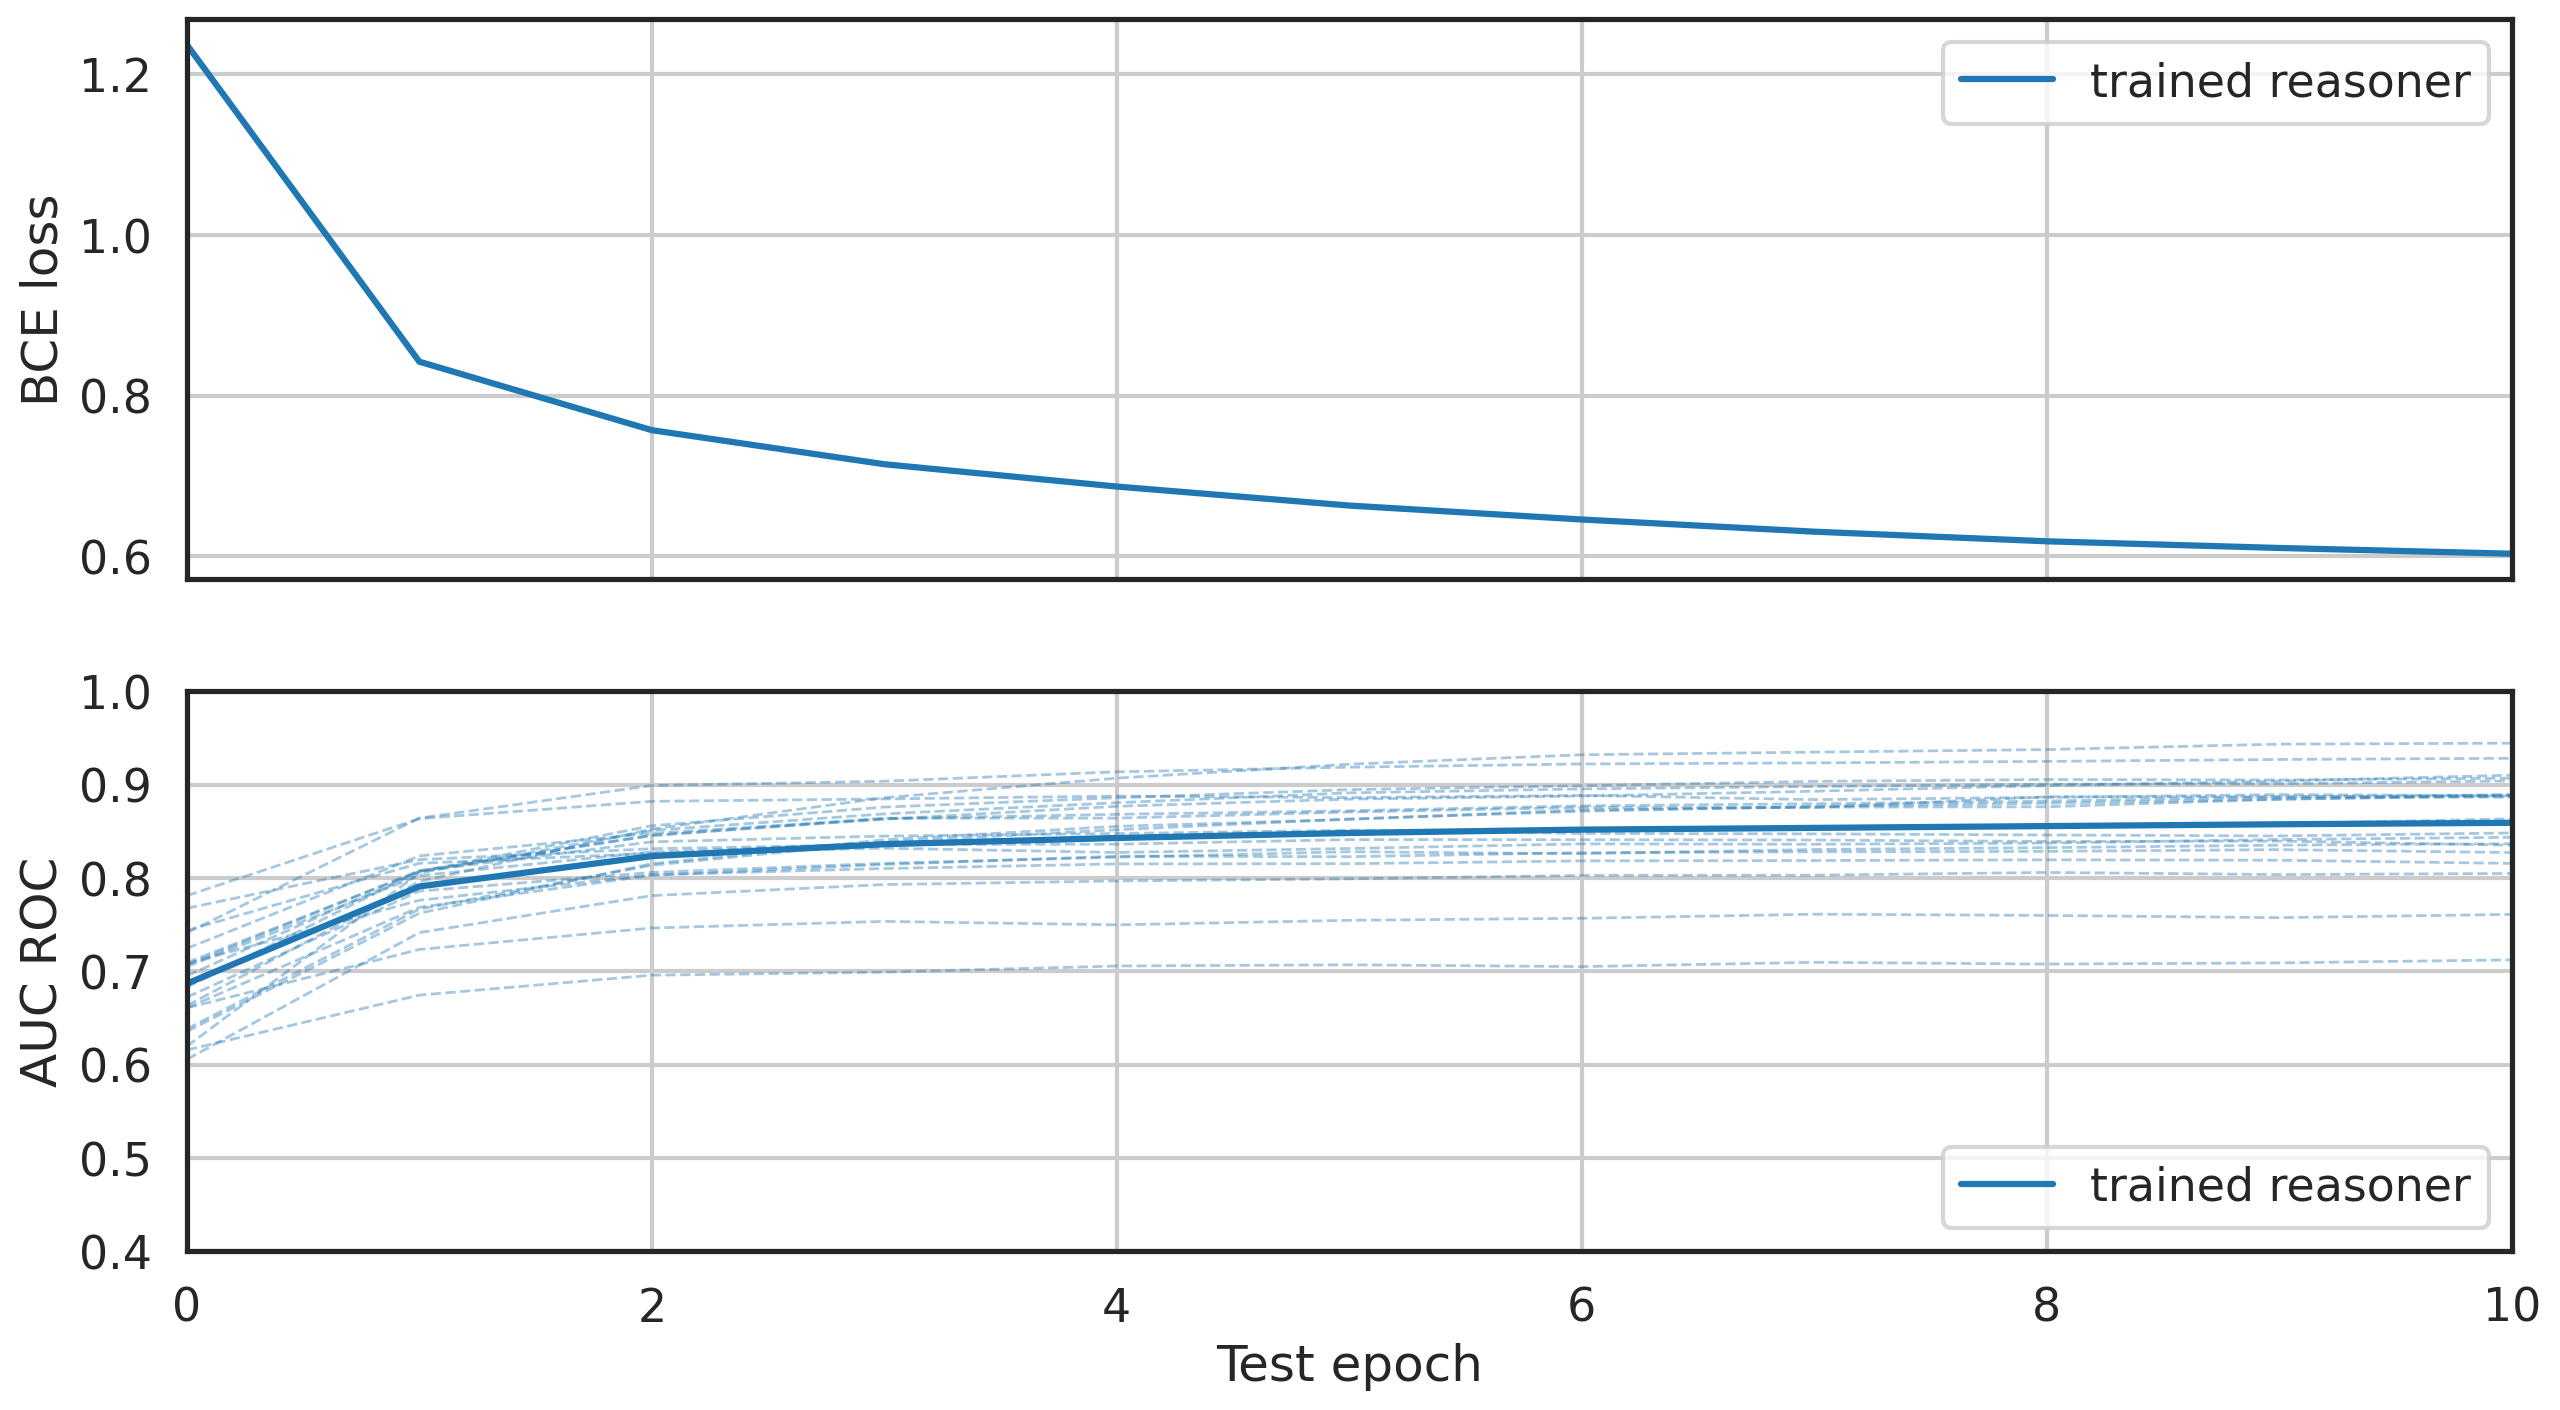

             mean       std     micro
acc      0.818592  0.047859  0.818888
prec     0.554467  0.094500  0.548128
recall   0.770272  0.088070  0.761516
f1       0.638126  0.070726  0.637438
auc_roc  0.877763  0.048315  0.872655
auc_pr   0.805914  0.058769  0.800287


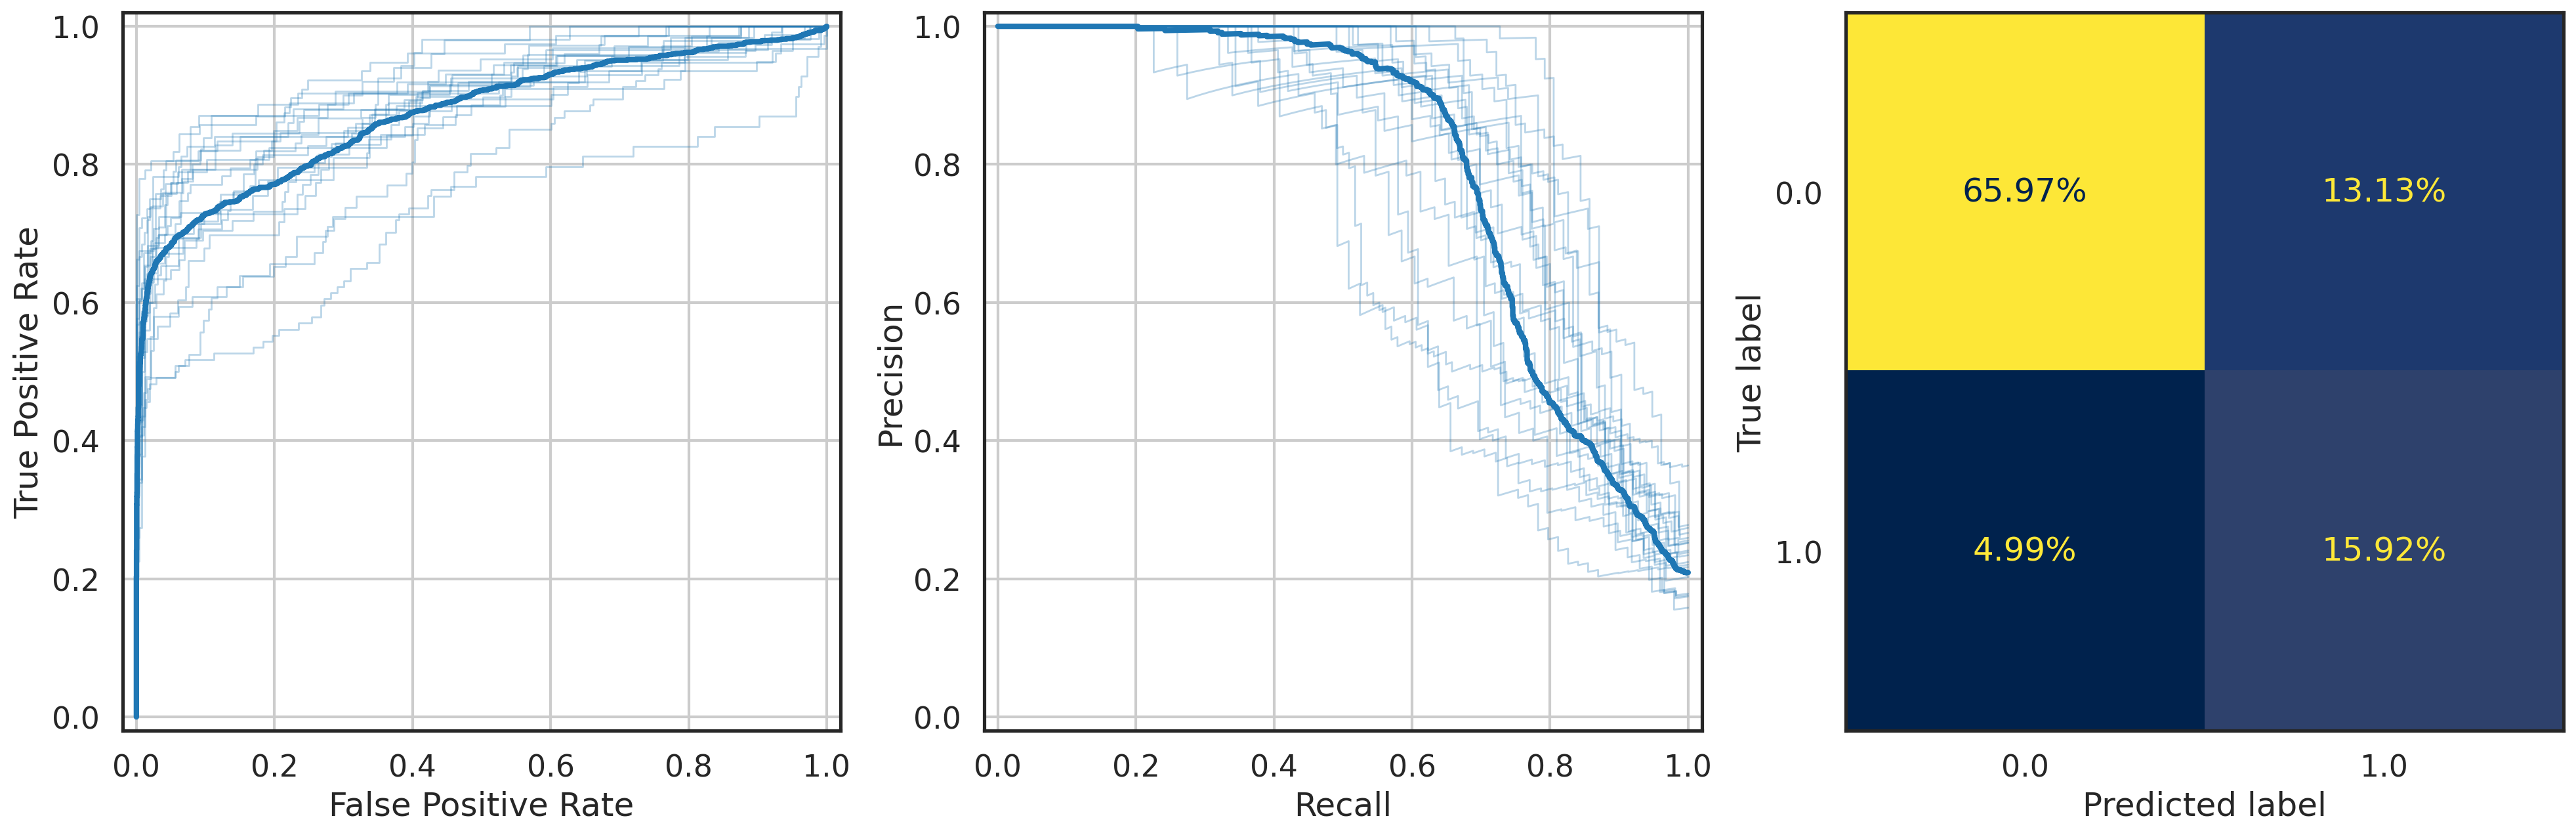

In [39]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [40]:
import random

In [41]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.1091,  0.0295, -0.1847,  0.0827,  0.0769, -0.1047,  0.0183, -0.0960,
         0.1832,  0.2310], grad_fn=<SelectBackward0>)
tensor([ 0.1220, -0.1305,  0.0943, -0.1588,  0.0943, -0.0698, -0.0467, -0.0527,
         0.0027,  0.0758], grad_fn=<AddBackward0>)
0.13372109942138194


In [43]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5413,  0.2065,  0.1473, -0.3378,  0.4724,  0.0014,  0.1224,  0.2182,
        -0.3374, -0.2699], grad_fn=<AddBackward0>)
0.03937105257064104


In [45]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.1129, -0.0086, -0.0367,  0.1202,  0.0166, -0.1883, -0.1496,  0.0357,
         0.1053,  0.1125], grad_fn=<SelectBackward0>)
tensor([-0.0173, -0.0742,  0.0147,  0.0132, -0.0313, -0.0659, -0.0603, -0.0466,
         0.0533,  0.0443], grad_fn=<AddBackward0>)
0.09687391631305217


In [65]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.1686, -0.1311,  0.1273, -0.1664,  0.1689, -0.1944, -0.1014, -0.0693,
        -0.0697,  0.0769], grad_fn=<AddBackward0>)
0.18288353681564332


In [48]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.4583,  0.2395,  0.1590, -0.3344,  0.4590, -0.0595,  0.1135,  0.1671,
        -0.2914, -0.2250], grad_fn=<SelectBackward0>)
tensor([ 0.5010,  0.2390,  0.1577, -0.3360,  0.4850, -0.0593,  0.1147,  0.1676,
        -0.3045, -0.2252], grad_fn=<SqueezeBackward3>)
tensor(0.0087, grad_fn=<L1LossBackward0>)


In [50]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0591, -0.3377, -0.0532,  0.4513,  0.0746,  0.3900,  1.1205, -0.0056,
        -0.2022,  0.4371], grad_fn=<SelectBackward0>)
tensor([-0.0592, -0.3378, -0.0563,  0.4336,  0.0745,  0.3911,  1.0568, -0.0053,
        -0.2060,  0.4157], grad_fn=<SqueezeBackward3>)
tensor(0.0112, grad_fn=<L1LossBackward0>)


In [51]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.3381,  0.1056,  0.1398, -0.2744,  0.3334, -0.0652,  0.0310,  0.0506,
        -0.1832, -0.0857], grad_fn=<AddBackward0>)
tensor([ 0.2970,  0.0894,  0.1231, -0.2476,  0.3158, -0.0779,  0.0197,  0.0644,
        -0.1748, -0.1263], grad_fn=<AddBackward0>)
0.024103435268625618


In [52]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.2090,  0.0060,  0.1620, -0.1886,  0.2035, -0.1054, -0.0144, -0.0184,
        -0.0731, -0.0085], grad_fn=<AddBackward0>)
tensor([ 0.1987,  0.0112,  0.1473, -0.1856,  0.2184, -0.1123, -0.0409,  0.0186,
        -0.0971, -0.0414], grad_fn=<AddBackward0>)
0.025768666760995984


In [54]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0702, -0.0580,  0.0581,  0.2840,  0.0562,  0.1664, -0.0616, -0.0333,
         0.0499, -0.1070], grad_fn=<SelectBackward0>)
tensor([ 0.0227, -0.0648,  0.0539,  0.0915,  0.0418,  0.0008, -0.0587, -0.0068,
         0.0296,  0.0155], grad_fn=<AddBackward0>)
0.07531467415392398


In [55]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9996753454208374


In [56]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999744892120361
